### MNISTの画像を準備

超解像復元の問題は、(連続状態集合S, 可算有限行動集合A, 報酬関数R, 不明な遷移関数T, 初期状態の生起確立P)からなるマルコフ決定過程で表され、高解像の復元画像を表す各状態を表す$s \in \mathbb{R}^{h \times w}$に顕微鏡でのぼやけ具合を表すフィルタを畳み込んだ値と、目標値である低解像度画像$ b \in \mathbb{R}^{(h - p + 1) \times (w - q + 1)}$との差を用いた報酬
$$ R = - \| s - b \|^2 $$
の総和を最大化するような、適切な行動(フィルタ)を決定的方策を学習する課題であると見なす事ができる。 

ここで、問題になるのは、状態集合が連続値で、一回の決定でたどり着ける状態とたどり着けない状態が存在も存在するし、さらには初期状態によって永遠にたどり着けない状態も存在する事である。この問題を解消しないと詰むのでは？  
-> 周期性のないマルコフ決定過程が強化学習問題において、問題なく最適な決定的方策を学習する事ができうるのかを調べる。

In [2]:
import random
from collections import deque, namedtuple

import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import fftconvolve
from tqdm.notebook import tqdm

device = tc.device('cuda:0')
random.seed(0)
tc.random.manual_seed(0)

In [3]:
# データは num = 0の画像のみ
transform = transforms.Compose([transforms.ToTensor()])
trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
trainset = trainset.data[trainset.targets <= 5]
trainset = trainset.reshape(trainset.shape[0], 1, 28, 28)

testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
testset = testset.data
testset = testset.reshape(testset.shape[0], 1, 28, 28)

print(trainset.shape)
print(testset.shape)

torch.Size([36017, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [15]:
with open('kernel.npy', 'rb') as f:
    kernel = np.load(f)
kernel = tc.tensor(kernel)
kernel

tensor([[0.0352, 0.0387, 0.0399, 0.0387, 0.0352],
        [0.0387, 0.0425, 0.0438, 0.0425, 0.0387],
        [0.0399, 0.0438, 0.0452, 0.0438, 0.0399],
        [0.0387, 0.0425, 0.0438, 0.0425, 0.0387],
        [0.0352, 0.0387, 0.0399, 0.0387, 0.0352]], dtype=torch.float64)

In [5]:
class Lista(nn.Module):
    def __init__(self):
        # params: Q, P, theta
        super(Lista, self).__init__()
        
        # 層数
        self.T = 5
        
        # 1層目
        self.conv_Q1 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta1 = nn.Parameter(tc.tensor(0.0))
        
        # 2層目
        self.conv_P2 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q2 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta2 = nn.Parameter(tc.tensor(0.0))
        
        # 3層目
        self.conv_P3 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q3 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta3 = nn.Parameter(tc.tensor(0.0))
        
        # 4層目
        self.conv_P4 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q4 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta4 = nn.Parameter(tc.tensor(0.0))
        
        # 5層目
        self.conv_P5 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q5 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta5 = nn.Parameter(tc.tensor(0.0))
        
        self.pre_activation_params = None # 最終層の活性化関数の入力
        
    def forward(self, b):
        # 1層目
        v = self.first_layer(b=b)
        # 2層目
        v = self.second_layer(v=v, b=b)
        # 3層目
        v = self.third_layer(v=v, b=b)
        # 4
        v = self.fourth_layer(v=v, b=b)
        # 5
        v = self.fifth_layer(v=v, b=b)
        return v
    
    def first_layer(self, b, v=None):
        v = self.conv_Q1(b)
        return tc.sign(v) * F.relu(v - self.theta1)
    
    def second_layer(self, b, v):
        v = self.conv_P2(v) + self.conv_Q2(b)
        return tc.sign(v) * F.relu(v - self.theta2)
    
    def third_layer(self, b, v):
        v = self.conv_P3(v) + self.conv_Q3(b)
        return tc.sign(v) * F.relu(v - self.theta3)
    
    def fourth_layer(self, b, v):
        v = self.conv_P4(v) + self.conv_Q4(b)
        return tc.sign(v) * F.relu(v - self.theta4)
    
    def fifth_layer(self, b, v):
        v = self.conv_P5(v) + self.conv_Q5(b)
        self.pre_activation_params = v
        return tc.sign(v) * F.relu(v - self.theta5)

In [6]:
lista = Lista()
lista.load_state_dict(tc.load('lista.pth'))
lista.to(device, dtype=tc.double)
mse_loss = nn.MSELoss()

In [57]:
image = trainset[0][0]
image = image.to(device)
print(image.shape)
im = tc.tensor(fftconvolve(image.cpu(), kernel, mode='same')).to(device)
out = lista(im.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
mse_loss(out, image).item()

torch.Size([28, 28])


1297.185205490709

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 6, 5)
        self.conv3 = nn.Conv2d(6, 4, 5)
        self.conv_transpose1 = nn.ConvTranspose2d(4, 6, 5)        
        self.conv_transpose2 = nn.ConvTranspose2d(6, 8, 5)
        self.conv_transpose3 = nn.ConvTranspose2d(8, 1, 5)
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
        
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = F.relu(self.conv_transpose3(x))
        return x
    
AE_MNIST = AutoEncoder()
AE_MNIST.load_state_dict(tc.load('AE_mnist16x16.pth'))
AE_MNIST.to(device, dtype=tc.double)

AutoEncoder(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv_transpose1): ConvTranspose2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_transpose2): ConvTranspose2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv_transpose3): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
)

### 環境を用意する
ガウシアンフィルタで３回ぼかした画像を初期state、元の画像を目標画像とする。  
本来の超解像復元では、目標画像が顕微鏡のぼやけフィルタとノイズを経た低解像度画像が目標画像。

In [45]:
# Actions: [1層目の処理, 2層目の処理, 3層目の処理, 4層目の処理, 5層目の処理, 終了]
actions = [lista.first_layer, lista.second_layer, lista.third_layer, lista.fourth_layer, lista.fifth_layer]

class InnerState(object):
    def __init__(self, now_img, init_img):
        # init_stateはスカラにしたほうがいい？
        if not tc.is_tensor(now_img):
            now_img = tc.tensor(now_img).to(device)
        if not tc.is_tensor(init_img):
            init_img = tc.tensor(init_img).to(device)
        self.x = tc.stack([now_img, init_img])
    
    @property
    def now(self):
        return self.x[0]
    
    @property
    def init(self):
        return self.x[1]
        
class OuterState(object):
    def __init__(self, inner_state):
        # Add chunnel
        with tc.no_grad():
            now = inner_state.now.unsqueeze(0).unsqueeze(0)
            now = AE_MNIST.encode(now).squeeze(0)
            init = inner_state.init.unsqueeze(0).unsqueeze(0)
            init = AE_MNIST.encode(init).squeeze(0)
        self.v = tc.cat([now, init])
# 最終的には、これがオートエンコーダーで特徴量抽出したものになる。
# class OuterState(object):
#     def __init__(self, inner_state):
#         # とりあえずそのまま使う
#         self.v = inner_state.x
        

END = lista.T
class ReconstructionEnv(object):
    def __init__(self, train=True):
        self._state = None
        self.train = train
        self._step_count = 0
    
    def reset(self):
        '''
        数字が0のデータからサンプルを選んでくる。
        1)targetとなる画像を、self._bに
        2)targetをぼかした画像を、self._stateにセット
        '''
        self._step_count = 0
        
        #1) 目標画像の準備
        if self.train:
            self._b = trainset[tc.randint(0, trainset.shape[0], ())][0] # (28, 28)
        else:
            self._b = testset[tc.randint(0, testset.shape[0], ())][0] # (28, 28)
        #2) kernelsの順番でぼかす。するとactionsを前から順番に採用するのが最高のはず
        self.init_state = fftconvolve(self._b.numpy(), kernel, mode='same')
        self._b = self._b.to(device)
        self.init_state = tc.tensor(self.init_state).to(device)
        
        with tc.no_grad():
            net_out = lista(self.init_state.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            self.lista_score = mse_loss(net_out, self._b)
            print(self.lista_score)
        
        self._state = InnerState(self.init_state, self.init_state)
        
    @property
    def state(self):
        return OuterState(self._state)
    
    def next_state(self, action):
        if action == END:
            return self._state
        action_layer = actions[action]
        now_state = self._state.now.unsqueeze(0).unsqueeze(0)
        init_state = self._state.init.unsqueeze(0).unsqueeze(0)
        with tc.no_grad():
            out = action_layer(v=now_state, b=init_state).squeeze(0).squeeze(0)
        return InnerState(out, self.init_state)
    
    def reward_func(self, state, action, next_state, penalty=-100.0):
        current_loss = mse_loss(next_state.now, self._b)
        
        if action == END:
            # 終了を選んだ際にListaの結果より誤差が大きかったらpenalty
            if current_loss > self.lista_score:
                return penalty
            return (-1) * penalty

        r = -1.0
        diff = mse_loss(state.now, self._b) - current_loss
        if diff > 0:
            r = r + penalty
        # 層の数より多い回数のフィルタを選んだら大幅にペナルティ
        if self._step_count >= lista.T:
            r = r + penalty
        return -1.0
    
    def step(self, action):
        self._step_count += 1  # インクリメント
        next_state = self.next_state(action)
        reward = self.reward_func(self._state, action, next_state)
        done = (action == END)  # 5回フィルタをかけたら終わり
        self._state = next_state  # そのまま代入して大丈夫。今回の環境では次の状態が常に存在するので。
        return OuterState(next_state), reward, done

### AgentにValueベースの方策を学習させて行動評価させる

In [21]:
LAST_FILTER_WIDTH = 1
class ConvQualityFunction(nn.Module):
    def __init__(self, action_dim):
        super(ConvQualityFunction, self).__init__()
        self.conv1 = nn.Conv2d(8, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, action_dim)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH)
        x = F.relu(
            self.dropout1(self.fc1(x))
        )
        x = F.relu(
            self.dropout2(self.fc2(x))
        )
        return self.fc3(x)


class DQNAgent(object):
    def __init__(self, action_dim=lista.T + 1, eps=0.1, lr=0.1, gamma=0.9):
        self.action_dim = action_dim
        self.eps = eps
        self.gamma = gamma
        self.Q_function = ConvQualityFunction(action_dim)
        self.Q_function.to(device)
        self.teacher_model = ConvQualityFunction(action_dim)
        self.teacher_model.to(device)
#         self.criterion = nn.MSELoss()
        self.criterion = F.smooth_l1_loss
        self.optimizer = optim.RMSprop(self.Q_function.parameters(), lr=lr)
    
    def policy(self, state, train=False):
        if train and tc.rand(()) < self.eps:
            return tc.randint(self.action_dim, ())
        with tc.no_grad():
            action_qualities = self.Q_function(state.v.unsqueeze(0))
        # Valueベースでactionを決定する
        return tc.argmax(action_qualities)
    
    def update(self, batch):
        # Experience Replayに基づいて行動評価関数のパラメーターを更新する。
        estimation_qualities = []
        true_qualities = []
        for i, e in enumerate(batch):
            est = self.Q_function(e.s.v)
            v = e.r
            if not e.d:
                with tc.no_grad():
                    v += self.gamma * tc.max(self.teacher_model(e.ns.v))
            estimation_qualities.append(est[e.a])
            true_qualities.append(v)
        estimation_qualities = tc.stack(estimation_qualities)
        true_qualities = tc.tensor(true_qualities).to(device)
        self.optimizer.zero_grad()
        loss = self.criterion(estimation_qualities, true_qualities)
        loss.backward()
        self.optimizer.step()
    
    def update_teacher(self):
        self.teacher_model.load_state_dict(self.Q_function.state_dict())

In [10]:
Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))


def train(agent, seed=0, train_episode_num=10000, teacher_update_freq=3):
    experiences = deque(maxlen=1024)
    train_count = 0
    reward_records = []
    
    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        env = ReconstructionEnv()
        env.reset()
        for i in range(10):
            action = agent.policy(env.state, train=True)
            next_state, reward, done = env.step(action)
            e = Experience(env.state, action, next_state, reward, done)
            Ri += reward
            if done:
                break
            
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            agent.update(batch)
            train_count += 1
        
        if train_count % teacher_update_freq == 0:
            agent.update_teacher()
        
        reward_records.append(Ri)
    return reward_records

In [20]:
seed = 0
agent = DQNAgent(eps=0.3, lr=0.1)
agent.Q_function.to(device, dtype=tc.double)
agent.teacher_model.to(device)
rewards = train(agent, train_episode_num=10000)

In [22]:
def moving_average(r, n=100):
    ret = tc.cumsum(r, dim=0, dtype=tc.float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

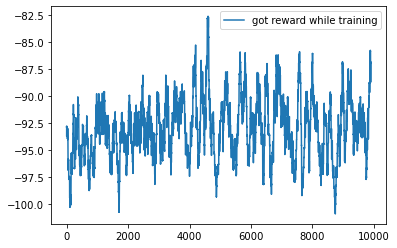

In [23]:
plt.plot(moving_average(tc.tensor(rewards), n=100), label='got reward while training')
plt.legend(loc='best')

In [34]:
action_labels = ['first_layer', 'second_layer', 'third_layer', 'fourth_layer', 'fifth_layer', 'END']
def test_policy(agent, fixed_action=None, max_iter=10):
    env = ReconstructionEnv()
    env.reset()
    done = False
    fig = plt.figure(figsize=(2, 2))
    plt.title('target')
    plt.imshow(env._b.cpu())
    plt.axis('off')
    plt.show()
    
    images = [env._state.x[0].cpu()]
    fig = plt.figure(figsize=(30, 6))
    print('回数 = ', lista.T)
    took_actions = []
    for _ in range(max_iter):
        if fixed_action is None:
            a = agent.policy(env.state)
        else:
            a = fixed_action
        took_actions.append(action_labels[a])
        next_state, reward, done = env.step(a)
        if done:
            break
        images.append(env._state.now.cpu())
    print('step_count', env._step_count)
    for i, image in enumerate(images, start=1):
        plt.subplot(1, len(images), i)
        plt.imshow(image)
        plt.axis('off')
    print('lista score:', env.lista_score.item())
    print('now score', mse_loss(env._b, env._state.now).item())
    plt.show()
    print(took_actions)

tensor(1028.5232, device='cuda:0', dtype=torch.float64)


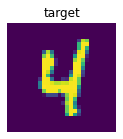

回数 =  5
step_count 3
lista score: 1028.523197033609
now score 6640.963046486816


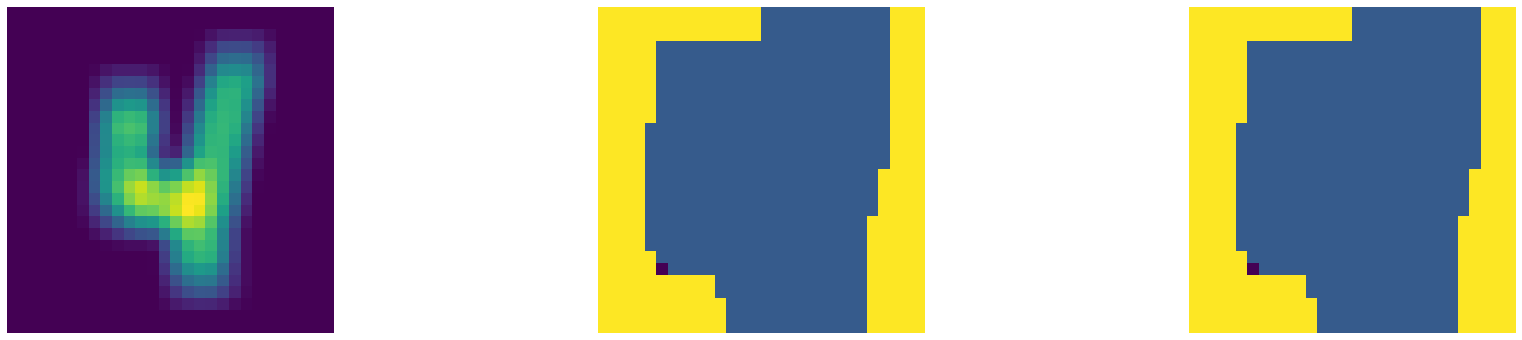

['first_layer', 'first_layer', 'END']


In [46]:
test_policy(agent=agent)

In [43]:
env = ReconstructionEnv()
loss_fn = nn.MSELoss()
env.reset()
losses = []
for i in range(5):
    for i in range(i):
        next_state, reward, done = env.step(i)
    loss = loss_fn(env._state.now, env._b)
    losses.append(loss)

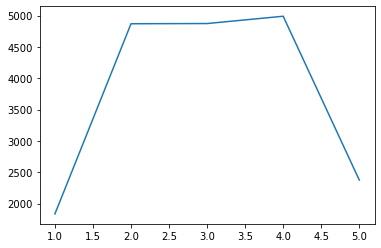

In [44]:
plt.plot(range(1, 6), losses)

In [67]:
count = 0
for _ in tqdm(range(60000)):
    env = ReconstructionEnv(train)
    loss_fn = nn.MSELoss()
    losses = []
    for i in range(1, 6):
        env.reset()
        for i in range(i):
            next_state, reward, done = env.step(i)
        loss = loss_fn(env._state.now, env._b)
        losses.append(loss)
    if np.argmin(losses) < 4:
        count += 1
count

840